In [1]:
import rasterio
from rasterio.plot import show as rastershow
from rasterio import mask

import sqlite3
import pandas as pd
import geopandas as gpd
import os

from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, box
import shapely

# Check finetuned polygons

A quick check to see if the generated polygons match expectations. Comparing the inference on a selected tile with 

- reference inference run (k=0)
- pretrained model (k=0)
- finetuned model (from k=0)

The results from reference inference and pretrained model should match!

In [2]:
test_tile = '/work/ka1176/shared_data/2024-ufz-deeptree/example_tiles/LVermGeo_DOP20/dop20rgbi_32_702_5706_2_st_2022.tif'

# This is the polygon frame that was generated in the first inference run
reference_sqlite = '/work/ka1176/shared_data/2024-ufz-deeptree/Halle-out-TCD-pretrained-rgbi/dop20rgbi_32_702_5706_2_st_2022_0.sqlite'

# This is the pretrained model
pretrained_sqlite = '/work/ka1176/caroline/gitlab/TreeCrownDelineation/results/inference_halle/2024-09-20_15-04-58/test.sqlite'

# This is the model finetuned on Halle data
finetuned_sqlite = '/work/ka1176/caroline/gitlab/TreeCrownDelineation/results/inference_halle/2024-09-20_15-09-14/test.sqlite'

In [3]:
def geoframe_from_sqlite(dbfile, col='test'):
    '''
    Create a GeoDataFrame with the geometries in the SQLITE database

    Arguments:
    dbfile (str): path to SQLITE database 
    '''

    if not os.path.exists(dbfile):
        print('No such file', dbfile)
        return None
    
    con = sqlite3.connect(dbfile)
    cur = con.cursor()
    try:
        df = pd.read_sql_query(f"SELECT * from {col}", con)
    except:
        print('Query failed for file', dbfile)
        return None
        
    con.close()
    geo = gpd.GeoSeries.from_wkb(df['GEOMETRY']).to_frame(f'geometry')

    return geo

In [4]:
reference_polygons = geoframe_from_sqlite(reference_sqlite, col='dop20rgbi_32_702_5706_2_st_2022_0')
pretrained_polygons = geoframe_from_sqlite(pretrained_sqlite, col='test')
finetuned_polygons = geoframe_from_sqlite(finetuned_sqlite)

rastertif = rasterio.open(test_tile)

In [5]:
# zoom in on a smaller region for better visibility
zoom_box = {'left':703000, 'right':703250, 'bottom':5706000, 'top':5706250}

zbox = Polygon( (Point(zoom_box['left'], zoom_box['bottom']), Point(zoom_box['right'], zoom_box['bottom']), Point(zoom_box['right'], zoom_box['top']), Point(zoom_box['left'], zoom_box['top']), ) )
zoom_reference = reference_polygons[reference_polygons.within(zbox)]
zoom_pretrained = pretrained_polygons[pretrained_polygons.within(zbox)]
zoom_finetuned = finetuned_polygons[finetuned_polygons.within(zbox)]
zoom_tif, _ = rasterio.mask.mask(rastertif, [zbox], crop=True)

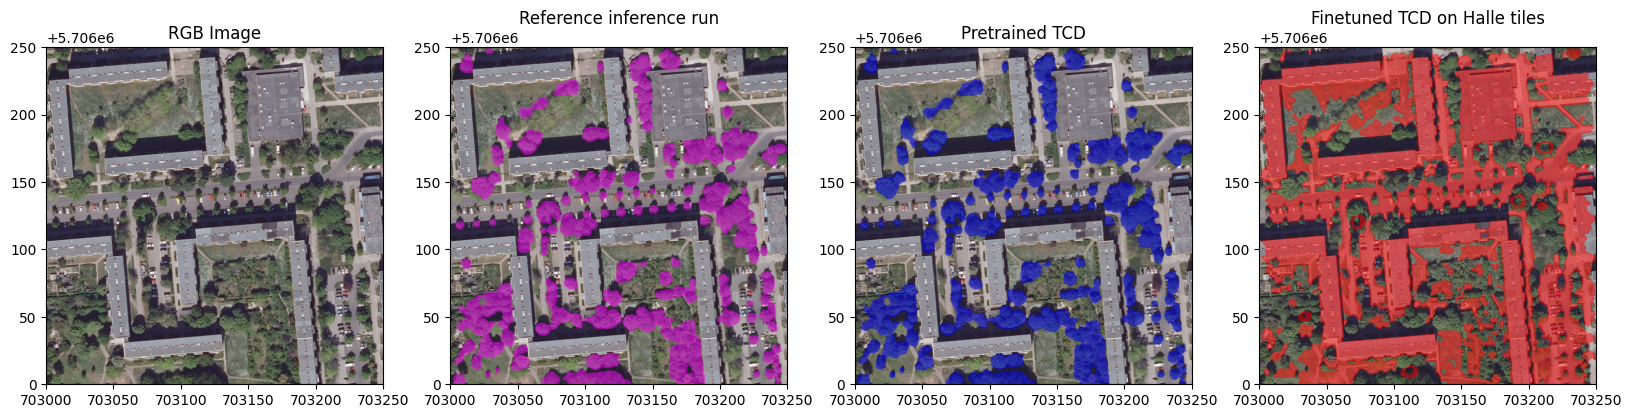

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20, 7))
ax[0].imshow(zoom_tif[:3].swapaxes(0,1).swapaxes(1,2), extent=[x[1] for x in zoom_box.items()])
ax[1].imshow(zoom_tif[:3].swapaxes(0,1).swapaxes(1,2), extent=[x[1] for x in zoom_box.items()])
zoom_reference.plot(ax=ax[1], color='magenta', alpha=0.5)

ax[2].imshow(zoom_tif[:3].swapaxes(0,1).swapaxes(1,2), extent=[x[1] for x in zoom_box.items()])
zoom_pretrained.plot(ax=ax[2], color='blue', alpha=0.5)

ax[3].imshow(zoom_tif[:3].swapaxes(0,1).swapaxes(1,2), extent=[x[1] for x in zoom_box.items()])
zoom_finetuned.plot(ax=ax[3], color='red', alpha=0.5)

ax[0].set_title('RGB Image')
ax[1].set_title('Reference inference run')

ax[2].set_title('Pretrained TCD')
ax[3].set_title('Finetuned TCD on Halle tiles')

plt.show()

In [7]:
# Show intersection and union
all_pretrained = zoom_pretrained.union_all()
all_finetuned = zoom_finetuned.union_all()

In [8]:
geom_inters = shapely.intersection(all_pretrained, all_finetuned)
geom_diff   = shapely.symmetric_difference(all_pretrained, all_finetuned)

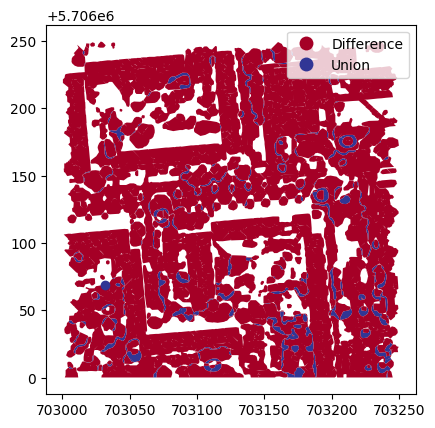

In [9]:
tmp = gpd.GeoDataFrame(dict(geometry=[geom_inters, geom_diff], label=['Union', 'Difference']))
tmp.plot(column='label', legend=True, cmap='RdYlBu')
plt.show()